In [63]:
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import itertools
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import autocast, GradScaler

from dataset import FacialLandmarkDataset

In [64]:
basic_augmentations = A.Compose([
    A.Resize(224, 224),  # Resize images to 512x512
    A.HorizontalFlip(p=0.5),  # 50% probability of horizontal flipping
    A.RandomBrightnessContrast(p=0.2),  # Simulate grayscale by altering brightness
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=30, p=0.5),  # Translation, scaling, rotation
    ToTensorV2(),  # Convert to PyTorch Tensor
], keypoint_params=A.KeypointParams(format='xy'))

In [65]:
# Initialize dataset
dataset = FacialLandmarkDataset(root_dir='archive/ibug_300W_large_face_landmark_dataset/', xml_path='archive\ibug_300W_large_face_landmark_dataset\labels_ibug_300W_train.xml', transform=basic_augmentations)

In [66]:
train_size = len(dataset) // 6
val_size = len(dataset) - train_size

# Split the dataset into train and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for both sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

In [67]:
train_loader.__len__()

35

68


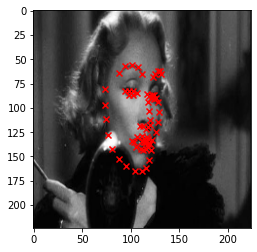

In [68]:
img, landmarks = dataset[45]

if isinstance(img, torch.Tensor):
    img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

print(len(landmarks))

# Convert to NumPy array for plotting
img_np = np.array(img)

# Plot image
plt.imshow(img_np)
plt.scatter(landmarks[:, 0], landmarks[:, 1], c='r', marker='x')

In [69]:
for i in range(len(dataset)):
    img, landmarks = dataset[i]
    if img is None or len(landmarks) == 0:
        print(f"Empty or invalid data at index {i}")


In [70]:
# Lookahead wrapper for PyTorch optimizers
class Lookahead(torch.optim.Optimizer):
    def __init__(self, base_optimizer, k=5, alpha=0.5):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid alpha parameter: {alpha}')
        if not k >= 1:
            raise ValueError(f'Invalid k parameter: {k}')
        self.base_optimizer = base_optimizer
        self.k = k
        self.alpha = alpha
        self.param_groups = self.base_optimizer.param_groups
        self.slow_weights = [[p.clone().detach() for p in group['params']]
                             for group in self.param_groups]
        for w in itertools.chain(*self.slow_weights):
            w.requires_grad = False
        self.counter = 0

    def step(self, closure=None):
        loss = self.base_optimizer.step(closure)
        self.counter += 1
        if self.counter % self.k == 0:
            for group, slow_weights in zip(self.param_groups, self.slow_weights):
                for p, q in zip(group['params'], slow_weights):
                    if p.grad is None:
                        continue
                    q.data.add_(self.alpha, p.data - q.data)
                    p.data.copy_(q.data)
        return loss

    def zero_grad(self):
        self.base_optimizer.zero_grad()


In [71]:
class DCCALoss(nn.Module):
    def __init__(self):
        super(DCCALoss, self).__init__()

    def forward(self, H1, H2):
        H1 = H1 - H1.mean(dim=0, keepdim=True)
        H2 = H2 - H2.mean(dim=0, keepdim=True)
        H1H2_cov = (H1.T @ H2) / (H1.size(0) - 1)
        H1_var = (H1.T @ H1) / (H1.size(0) - 1)
        H2_var = (H2.T @ H2) / (H2.size(0) - 1)
        H1_var_sqrt = torch.sqrt(torch.trace(H1_var))
        H2_var_sqrt = torch.sqrt(torch.trace(H2_var))
        corr = torch.trace(H1H2_cov) / (H1_var_sqrt * H2_var_sqrt)
        return -corr

In [72]:
def local_soft_argmax(heatmap, temperature=0.5):
    softmax = F.softmax(heatmap.view(-1) / temperature, dim=0)
    height, width = heatmap.shape
    softmax = softmax.view(height, width)
    
    y_grid, x_grid = torch.meshgrid(torch.arange(height), torch.arange(width), indexing='ij')
    
    x_coord = (x_grid.float() * softmax).sum()
    y_coord = (y_grid.float() * softmax).sum()
    
    return x_coord, y_coord

In [73]:
def extract_landmark_coords_from_heatmaps(heatmaps, image_size=(224, 224)):
    batch_size, num_landmarks, height, width = heatmaps.size()
    coords = torch.zeros(batch_size, num_landmarks, 2, dtype=torch.float32).to(heatmaps.device)
    for b in range(batch_size):
        for l in range(num_landmarks):
            heatmap = heatmaps[b, l]
            if heatmap.sum() > 0:
                heatmap = heatmap / heatmap.sum()
            x, y = local_soft_argmax(heatmap)
            coords[b, l, 0] = torch.clamp(x * image_size[1] / width, min=0, max=image_size[1] - 1)
            coords[b, l, 1] = torch.clamp(y * image_size[0] / height, min=0, max=image_size[0] - 1)
    return coords

In [74]:
# Fiducial Focus Augmentation
def fiducial_focus_augmentation(image_tensor, landmarks, n, epoch, total_epochs):
    augmented_images = []
    patch_size = max(1, n - (epoch * n // total_epochs))  # Gradually reduce patch size

    for i in range(image_tensor.size(0)):  # Iterate over batch
        image = image_tensor[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to NumPy
        augmented_image = image.copy()
        image_landmarks = landmarks[i]

        for (x, y) in image_landmarks:
            x, y = int(x), int(y)
            top_left = (max(0, x - patch_size // 2), max(0, y - patch_size // 2))
            bottom_right = (min(image.shape[1], x + patch_size // 2), min(image.shape[0], y + patch_size // 2))

            # Apply black patch
            augmented_image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = (0, 0, 0)

        augmented_images.append(torch.from_numpy(augmented_image).permute(2, 0, 1))

    return torch.stack(augmented_images)

In [75]:
class BlurPool(nn.Module):
    def __init__(self, channels, stride=1):
        super(BlurPool, self).__init__()
        self.stride = stride
        self.pad = nn.ReflectionPad2d(1)
        self.blur_kernel = torch.tensor([[1., 2., 1.], [2., 4., 2.], [1., 2., 1.]])
        self.blur_kernel = self.blur_kernel / self.blur_kernel.sum()
        self.blur_kernel = self.blur_kernel.expand(channels, 1, 3, 3)

    def forward(self, x):
        x = self.pad(x)
        return F.conv2d(x, self.blur_kernel.to(x.device), stride=self.stride, groups=x.shape[1])

In [76]:
class FFParser(nn.Module):
    def __init__(self):
        super(FFParser, self).__init__()

    def forward(self, x):
        x_freq = torch.fft.fft2(x, dim=(-2, -1))
        x_filtered = torch.fft.ifft2(x_freq, dim=(-2, -1)).real
        return x_filtered

In [77]:
class HourglassModule(nn.Module):
    def __init__(self):
        super(HourglassModule, self).__init__()
        self.conv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.anti_alias = BlurPool(128, stride=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.ff_parser = FFParser()

    def forward(self, x):
        x = self.conv1(x)
        x = self.anti_alias(x)
        x = self.conv2(x)
        x = self.ff_parser(x)
        return x

In [78]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            # Kaiming Uniform for Conv layers (good for ReLU activations)
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        
        elif isinstance(m, nn.Linear):
            # Xavier Uniform for Linear layers (good for non-ReLU activations)
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        
        elif isinstance(m, nn.BatchNorm2d):
            # BatchNorm layers are typically initialized with weight=1 and bias=0
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        
        elif isinstance(m, nn.LayerNorm):
            # LayerNorm initialization (set weights to 1 and biases to 0)
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        
        elif isinstance(m, nn.Embedding):
            # Embeddings should be initialized with uniform distribution
            nn.init.uniform_(m.weight, -0.05, 0.05)
        
        elif isinstance(m, nn.LSTM) or isinstance(m, nn.GRU):
            # Initialize LSTM/GRU layers: Orthogonal initialization for recurrent weights
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param.data)
                elif 'bias' in name:
                    param.data.fill_(0)

In [79]:
class FacialLandmarkModel(nn.Module):
    def __init__(self, num_landmarks):
        super(FacialLandmarkModel, self).__init__()
        
        # ViT Backbone with pretrained weights
        self.vit_backbone = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        self.vit_backbone.head = nn.Identity()  # Removing the classification head

        # Reshape the output of the ViT backbone to match the input size for the hourglass module
        self.reshape = nn.Linear(768, 256 * 14 * 14)
        
        # Adding dropout after the reshaping
        self.dropout = nn.Dropout(p=0.2)

        # Hourglass module for feature extraction and localization
        self.hourglass = HourglassModule()

        # Final output convolution to predict heatmaps for the landmarks
        self.fc = nn.Conv2d(128, num_landmarks, kernel_size=1)
        
        # Initialize weights of the model
        initialize_weights(self)

    def forward(self, x):
        # Clamping input values to [0, 1]
        x = torch.clamp(x, min=0.0, max=1.0)
        
        # Extract features using the ViT backbone
        features = self.vit_backbone(x)
        
        # Reshape the ViT output and apply dropout
        features = self.reshape(features).view(-1, 256, 14, 14)
        features = self.dropout(features)  # Applying dropout here

        # Pass through the hourglass module
        features = self.hourglass(features)

        # Predict heatmaps for landmarks
        heatmaps = self.fc(features)
        
        return heatmaps

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FacialLandmarkModel(num_landmarks=68).to(device)

In [81]:
# Optimizer and Scheduler
base_optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
lookahead_optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)
scheduler = CosineAnnealingWarmRestarts(base_optimizer, T_0=10, T_mult=2, eta_min=1e-6)

# Gradient Scaler for mixed precision
scaler = GradScaler()

c:\Users\Luca\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\cuda\amp\grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [82]:
# Loss functions
dcca_loss = DCCALoss().to(device)
criterion_mse = nn.MSELoss().to(device)

max_grad_norm = 1.0 

In [83]:
# Função para plotar as previsões
def plot_predictions_during_training(images, coords_pred, landmarks, fiducial_focus_images, epoch, num_images=6):
    images_np = images.permute(0, 2, 3, 1).cpu().numpy()  # Converter para HWC para plotagem
    coords_pred_np = coords_pred.cpu().numpy()

    # Para as imagens com FiFA
    fiducial_images_np = fiducial_focus_images.permute(0, 2, 3, 1).cpu().numpy()

    fig, axs = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))  # Organiza as imagens em linhas
    
    for i in range(num_images):
        # Imagem original com previsões
        axs[i, 0].imshow(images_np[i])
        axs[i, 0].scatter(coords_pred_np[i][:, 0], coords_pred_np[i][:, 1], c='r', marker='x', label='Predicted')
        axs[i, 0].scatter(landmarks[i][:, 0].cpu(), landmarks[i][:, 1].cpu(), c='g', marker='o', label='Ground Truth')
        axs[i, 0].set_title(f"Original Image - Epoch {epoch}")
        axs[i, 0].legend()

        # Imagem com FiFA
        axs[i, 1].imshow(fiducial_images_np[i])
        axs[i, 1].scatter(coords_pred_np[i][:, 0], coords_pred_np[i][:, 1], c='r', marker='x', label='Predicted')
        axs[i, 1].scatter(landmarks[i][:, 0].cpu(), landmarks[i][:, 1].cpu(), c='g', marker='o', label='Ground Truth')
        axs[i, 1].set_title(f"Fiducial Focus Augmentation - Epoch {epoch}")
        axs[i, 1].legend()

    plt.tight_layout()
    plt.show()

In [84]:
num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_dcca_loss = 0.0
    running_mse_loss = 0.0

    for images, landmarks in train_loader:
        
        if images.size(0) == 0 or landmarks.size(0) == 0:
            print("Skipping batch with empty data")
            continue

        images, landmarks = images.to(device), landmarks.to(device)

        fiducial_focus_images = fiducial_focus_augmentation(images, landmarks, 20, epoch, num_epochs)

        # Reset gradients
        lookahead_optimizer.zero_grad()

        # Mixed precision
        with autocast():
            # Forward pass for original and augmented images
            outputs_original = model(images)
            outputs_transformed = model(fiducial_focus_images)

            # Extract coordinates from heatmaps
            coords_original = extract_landmark_coords_from_heatmaps(outputs_original)
            coords_transformed = extract_landmark_coords_from_heatmaps(outputs_transformed)

            # Reshape for DCCA loss calculation
            coords_original_flat = coords_original.view(coords_original.size(0), -1)
            coords_transformed_flat = coords_transformed.view(coords_transformed.size(0), -1)

            # Calculate DCCA loss and MSE loss
            loss_dcca = dcca_loss(coords_original_flat, coords_transformed_flat)
            loss_mse = criterion_mse(coords_original.view(-1, 68, 2), landmarks)

            # Combined loss
            loss = 0.2 * loss_dcca + 0.8 * loss_mse

        # Mixed precision scaling of the loss
        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(lookahead_optimizer)  # Unscales gradients before clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        # Optimizer step with mixed precision scaling
        scaler.step(lookahead_optimizer)
        scaler.update()

        running_loss += loss.item()
        running_dcca_loss += loss_dcca.item()
        running_mse_loss += loss_mse.item()

    avg_loss = running_loss / len(train_loader)
    avg_dcca_loss = running_dcca_loss / len(train_loader)
    avg_mse_loss = running_mse_loss / len(train_loader)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {avg_loss:.4f} (DCCA: {avg_dcca_loss:.4f}, MSE: {avg_mse_loss:.4f})")

    scheduler.step(epoch + 1)

    if (epoch + 1) % 25 == 0:
        with torch.no_grad():
            model.eval()
            images, landmarks = next(iter(train_loader))
            images, landmarks = images.to(device), landmarks.to(device)

            # Generate the outputs and predictions
            outputs = model(images)
            coords_pred = extract_landmark_coords_from_heatmaps(outputs)

            # Apply Fiducial Focus Augmentation to test images
            fiducial_focus_images = fiducial_focus_augmentation(images, landmarks, n=20, epoch=epoch, total_epochs=num_epochs)

            # Visualizar previsões e mapas de calor
            plot_predictions_during_training(images, coords_pred, landmarks, fiducial_focus_images, epoch)

c:\Users\Luca\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [ ]:
model_save_path = 'best_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

In [212]:
# Sample function to get normalization factors (e.g., inter-ocular distance)
def get_normalization_factors(landmarks_batch):
    left_eye = landmarks_batch[:, 36, :]  # Coordinates for left eye (landmark index 36)
    right_eye = landmarks_batch[:, 45, :]  # Coordinates for right eye (landmark index 45)
    normalization_factors = torch.norm(left_eye - right_eye, dim=-1)  # Inter-ocular distance
    return normalization_factors

In [213]:
# NME calculation
def calculate_nme(preds, labels, normalization_factor):
    error = torch.norm(preds - labels, dim=-1)  # Euclidean distance for each landmark
    nme = error.mean(dim=1) / normalization_factor  # Mean error per image, normalized
    return nme.mean()  # Return the average NME across the batch

In [214]:
# Evaluate model function
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_nme = 0.0
    criterion = torch.nn.MSELoss()

    with torch.no_grad():
        for images, landmarks in test_loader:
            images, landmarks = images.to(device), landmarks.to(device)

            # Forward pass
            outputs = model(images)

            # Extract predicted coordinates from heatmaps
            predicted_coords = extract_landmark_coords_from_heatmaps(outputs)

            # Calculate MSE loss with ground truth landmarks
            mse_loss = criterion(predicted_coords.view(-1, 68, 2), landmarks)

            # Compute normalization factors for the current batch
            norm_factors = get_normalization_factors(landmarks)

            # Calculate NME for the current batch
            nme = calculate_nme(predicted_coords.view(-1, 68, 2), landmarks, norm_factors)

            total_loss += mse_loss.item()
            total_nme += nme.item()

    avg_loss = total_loss / len(test_loader)
    avg_nme = total_nme / len(test_loader)

    print(f"Test Loss (MSE): {avg_loss:.4f}, NME: {avg_nme:.4f}")
    return avg_loss, avg_nme

In [215]:
# Plot predictions function with better visualization
def plot_predictions(model, test_loader, image_size=(224, 224), num_images=5):
    model.eval()
    images_shown = 0
    with torch.no_grad():
        for images, landmarks in test_loader:
            images = images.to(device)
            outputs = model(images)
            coords_pred = extract_landmark_coords_from_heatmaps(outputs, image_size).cpu().numpy()
            images_np = images.permute(0, 2, 3, 1).cpu().numpy()  # Convert to HWC format for plotting

            # Plot a few images with their predicted landmarks
            for i in range(len(images)):
                plt.imshow(images_np[i])
                plt.scatter(coords_pred[i][:, 0], coords_pred[i][:, 1], c='r', marker='x', label='Predicted')
                plt.scatter(landmarks[i][:, 0], landmarks[i][:, 1], c='g', marker='o', label='Ground Truth')
                plt.title(f"Predicted vs Ground Truth Landmarks")
                plt.legend()
                plt.show()

                images_shown += 1
                if images_shown >= num_images:
                    return  # Stop after showing the specified number of images